In [559]:
import time

import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
from toolsets.file_io import get_file_list
import toolsets.T_rex as trx
import toolsets.raw_data_scaffold as rds
from toolsets.constants import iso_steps
mzml_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/benchmarking_dataset/mzml'
pl_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/benchmarking_dataset/pl'
eic_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/benchmarking_dataset/eic'
master_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/benchmarking_dataset'
seminar_dir ='/Users/fanzhoukong/Documents/GitHub/Libgen_data/benchmarking_dataset/seminar'
from toolsets.search import search_feature, quick_search_values,string_search, quick_search_sorted
for f in [mzml_dir, pl_dir, eic_dir,seminar_dir]:
    if os.path.exists(f)==False:
        os.makedirs(f)
file_list = get_file_list(mzml_dir, '.mzML', with_tail=False)
import scipy
from scipy.signal import find_peaks, peak_prominences
from tqdm import tqdm
n_neighbor=10
intensity_threshold = 30000

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [560]:
std_list = pd.read_csv(os.path.join(master_dir, 'std_list.csv'))

In [561]:
std_list_intensity = std_list.copy()

In [562]:
for f in tqdm(file_list):
    feature_temp = pd.read_csv(os.path.join(pl_dir, f+'.csv'))
    feature_temp.sort_values(by = 'precursor_mz', ascending=True, inplace=True)
    intensity_file = []
    for index, row in std_list.iterrows():
        feature_matched = search_feature(feature_temp, pmz=row['m/z'], rt=row['rt'], rt_error=21, pmz_sorted=True)
        if len(feature_matched)>0:
            feature_matched.sort_values(by ='ms1_intensity', ascending=False, inplace=True)
            intensity_file.append(feature_matched.iloc[0]['ms1_intensity'])
            # pass
        else:
            intensity_file.append(np.NAN)
    std_list_intensity[f]=intensity_file

100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


In [571]:
sa_cv = []
sb_cv = []
sa_file = [x for x in file_list if 'SA' in x]
sb_file = [x for x in file_list if 'SB' in x]
for index, row in std_list_intensity.iterrows():
    cv_temp = np.std(row[sa_file])/np.mean(row[sa_file])*100
    sa_cv.append(cv_temp)
    cv_temp = np.std(row[sb_file])/np.mean(row[sb_file])*100
    sb_cv.append(cv_temp)

In [574]:
len(sa_cv+sb_cv)

1672

In [575]:
df = pd.DataFrame(zip(sa_cv+ sb_cv, ['SA']*len(sa_cv)+['SB']*len(sb_cv)),columns=['CV', 'group'])

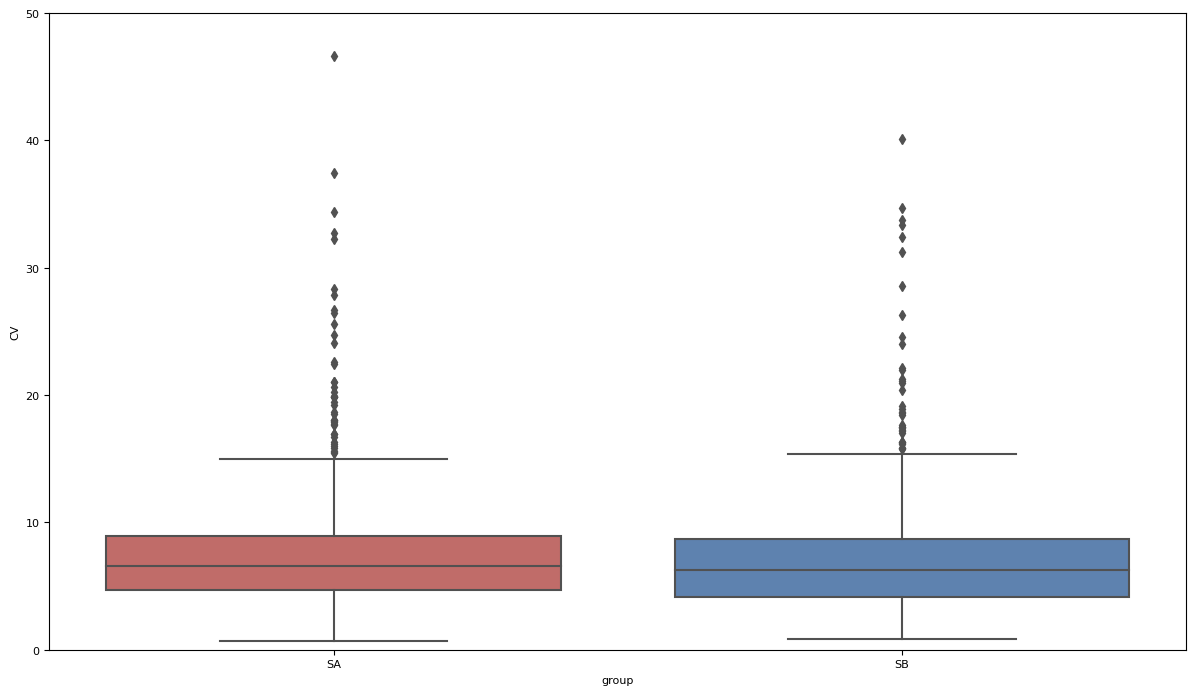

In [578]:
# my_colors = ["#CE5F5A", "#5081BD",'#61D837']
fig = plt.figure(figsize = (12, 7))
# add color array to set_palette
# function of seaborn
# p = sns.set_palette( my_colors )
ax = sns.boxplot(data=df, x="group", y="CV", )
# ax.set_ylabel('Time used (second)',fontsize = 18)
# ax.set_xlabel('EIC methods', fontsize = 18)
ax.set_ylim(0,50)
# ax.tick_params(axis='both', which='major', labelsize=14)
# ax.tick_params(axis='both', which='minor', labelsize=14)
fig.tight_layout()
plt.savefig(os.path.join(seminar_dir, 'CV.png'))

In [160]:
def _check_halo(formula):
    if 'S' in formula or 'Cl' in formula or 'Br' in formula or 'F' in formula:
        return True
    else:
        return False

In [163]:
if_halo = []
for index, row in std_list.iterrows():
    if_halo.append(_check_halo(row['formula']))
    # break
std_list['if_halo_ref']=if_halo

In [ ]:
for f in file_list:
    feature_temp = pd.read_csv(os.path.join(pl_dir, f+'.csv'))
    ms1, ms2 = rds.read_mzml(f, mzml_dir)
    mass_sorted, intensity_sorted, index_sorted, rt_list = trx.build_index(ms1)
    for index, row in std_list.iterrows():
        found_feature = search_feature(feature_temp, )

In [35]:
from toolsets.constants import iso_steps

In [38]:
from scipy.stats import pearsonr

In [207]:
def is_halo(row, mass_sorted, intensity_sorted, index_sorted,threshold = 0.9):
    ion_trace_base = trx.moving_average(trx.flash_eic(row['precursor_mz'], mass_sorted, intensity_sorted, index_sorted),10)
    ion_trace_halo = trx.moving_average(trx.flash_eic(row['precursor_mz']+iso_steps['Cl'],mass_sorted, intensity_sorted, index_sorted),10)
    scan_range = literal_eval(row['ms1_scan_range'])
    corr,_ = pearsonr(ion_trace_base[scan_range[0]:scan_range[1]],
                       ion_trace_halo[scan_range[0]:scan_range[1]])
    if corr != corr:
        corr = 0
    if corr>threshold:
        return(True)
    else:
        return False

In [206]:
def is_mono(row, mass_sorted, intensity_sorted, index_sorted, threshold = 0.9):
    scan_range = literal_eval(row['ms1_scan_range'])
    ion_trace_base = trx.moving_average(trx.flash_eic(row['precursor_mz'], mass_sorted, intensity_sorted, index_sorted),10)
    ion_trace_left = trx.moving_average(trx.flash_eic(row['precursor_mz']-iso_steps['C'],mass_sorted, intensity_sorted, index_sorted),10)
    ion_trace_right = trx.moving_average(trx.flash_eic(row['precursor_mz']+iso_steps['C'],mass_sorted, intensity_sorted, index_sorted),10)

    corr_left,_ = pearsonr(ion_trace_base[scan_range[0]:scan_range[1]],
                           ion_trace_left[scan_range[0]:scan_range[1]])
    if corr_left!= corr_left:
        corr_left = 0
    corr_right,_ = pearsonr(ion_trace_base[scan_range[0]:scan_range[1]],
                            ion_trace_right[scan_range[0]:scan_range[1]])
    if corr_right!= corr_right:
        corr_right = 0
    if corr_left<threshold and corr_right>threshold:
        return(True)
    else:
        return(False)

In [208]:
report_df = std_list.copy()

for f in tqdm(file_list):
    feature_temp = pd.read_csv(os.path.join(pl_dir, f+'.csv'))
    ms1, ms2 = rds.read_mzml(f, mzml_dir)
    mass_sorted, intensity_sorted, index_sorted, rt_list = trx.build_index(ms1)
    feature_temp['mz_offset']=abs(feature_temp['precursor_mz']-feature_temp['ion_trace_center'])
    if_halo =[]
    if_mono = []
    found = []
    for index, row in (std_list.iterrows()):
        found_feature = search_feature(feature_temp, row['m/z'], row['rt'], rt_error=21)
        # if row['if_halo_ref']==True:
        #     break
        if len(found_feature)>0:
            found.append(True)
            if len(found_feature)>1:
                found_feature = found_feature[found_feature['ms1_intensity']>np.max(found_feature['ms1_intensity'])*0.9]
                found_feature.sort_values(by = 'mz_offset', ascending=True, inplace=True)
            if_halo.append(is_halo(found_feature.iloc[0], mass_sorted, intensity_sorted, index_sorted))

            if_mono.append(is_mono(found_feature.iloc[0], mass_sorted, intensity_sorted, index_sorted))
        else:
            found.append(False)
            if_halo.append(np.NAN)
            if_mono.append(np.NAN)
    report_df['halo_corr'+f]=if_halo
    report_df['corr_left'+f]=if_mono
    report_df['found'+f]=found

100%|██████████| 10/10 [04:48<00:00, 28.82s/it]


In [172]:
found_col = [x for x in report_df.columns if 'found' in x]
mono_col = [x for x in report_df.columns if 'corr_left' in x]
halo_col = [x for x in report_df.columns if 'halo_corr' in x]

In [176]:
from collections import Counter

In [209]:
fill_percent = []
mono_concensus = []
halo_concensus = []
for index, row in report_df.iterrows():
    fill_percent.append(np.sum(row[found_col])/len(found_col))
    mono_concensus.append(Counter(row[mono_col]).most_common()[0][0])
    halo_concensus.append(Counter(row[halo_col]).most_common()[0][0])
std_list['fill_%']=fill_percent
std_list['mono_concensus']=mono_concensus
std_list['halo_concensus']=halo_concensus

In [213]:
std_list['mono_concensus'].value_counts()

mono_concensus
True     662
False    169
Name: count, dtype: int64

In [214]:
662/(662+169)

0.7966305655836342

In [218]:
from metabengine.raw_data_utils import MSData
from metabengine.params import Params

In [220]:
metabo_ms = MSData()
params = Params()

12483 MS1 and 0 MS2 scans extracted.


In [265]:
ms1.to_csv(os.path.join(seminar_dir, 'ms1_temp.csv'))

In [224]:
metabo_ms.read_raw_data(os.path.join(mzml_dir, 'SA2.mzML'), params=params)
time_used_metabo = []
for i in tqdm(range(0,10000)):
    start = time.time()
    metabo_eic = metabo_ms.get_eic_data(371.1617, mz_tol=0.005)
    end = time.time()
    time_used_metabo.append(end-start)

100%|██████████| 10000/10000 [22:33<00:00,  7.39it/s] 


In [354]:
1/7.39*1E3

135.31799729364005

In [344]:
ms1, ms2 = rds.read_mzml('SA2', mzml_dir)
mass_sorted, intensity_sorted, index_sorted, rt_list = trx.build_index(ms1)

In [346]:
time_used_flash = []
for i in tqdm(range(0,10000)):
    start = time.time()
    # metabo_eic = metabo_ms.get_eic_data(371.1617, mz_tol=0.005)
    tt = trx.flash_eic(371.1617, mass_sorted, intensity_sorted, index_sorted)
    end = time.time()
    time_used_flash.append(end-start)

100%|██████████| 10000/10000 [00:26<00:00, 374.76it/s]


In [355]:
len(mass_sorted)

12051387

In [307]:
time_used_long = pd.DataFrame(zip(time_used_flash+time_used,['Flash EIC']*10000+['Numpy method']*10000),columns=['time_used','method'] )

In [292]:
np.mean(time_used_flash)/np.mean(time_used_flash)

1.0

In [294]:
import seaborn as sns
import matplotlib.pyplot as plt

In [363]:
ms1

,scan_idx,cycle,ms_level,precursor_mz,polarity,rt,peaks,isolation_window,mix,base_name
0,0,0,1,0.0,-,0.002853,"[[60.24489212036133, 5196.78271484375], [61.98...","(0.0, 0.0)",Exposome_Yendry232_MX743739_negBA_003-200-5,Exposome_Yendry232_MX743739_negBA_003-200-5.mzML
1,1,1,1,0.0,-,0.005308,"[[60.99036407470703, 5728.833984375], [61.9883...","(0.0, 0.0)",Exposome_Yendry232_MX743739_negBA_003-200-5,Exposome_Yendry232_MX743739_negBA_003-200-5.mzML
2,2,2,1,0.0,-,0.007614,"[[61.32615661621094, 1455.4471435546875], [61....","(0.0, 0.0)",Exposome_Yendry232_MX743739_negBA_003-200-5,Exposome_Yendry232_MX743739_negBA_003-200-5.mzML
3,3,3,1,0.0,-,0.009920,"[[61.98733901977539, 4016.0302734375], [61.988...","(0.0, 0.0)",Exposome_Yendry232_MX743739_negBA_003-200-5,Exposome_Yendry232_MX743739_negBA_003-200-5.mzML
4,4,4,1,0.0,-,0.012225,"[[61.1275520324707, 1974.6036376953125], [61.5...","(0.0, 0.0)",Exposome_Yendry232_MX743739_negBA_003-200-5,Exposome_Yendry232_MX743739_negBA_003-200-5.mzML
...,...,...,...,...,...,...,...,...,...,...
894,2232,894,1,0.0,-,3.784682,"[[61.98834228515625, 107801.25], [63.190063476...","(0.0, 0.0)",Exposome_Yendry232_MX743739_negBA_003-200-5,Exposome_Yendry232_MX743739_negBA_003-200-5.mzML
895,2234,895,1,0.0,-,3.788523,"[[61.20576858520508, 1830.6932373046875], [61....","(0.0, 0.0)",Exposome_Yendry232_MX743739_negBA_003-200-5,Exposome_Yendry232_MX743739_negBA_003-200-5.mzML
896,2237,896,1,0.0,-,3.793359,"[[60.432411193847656, 1720.98779296875], [61.9...","(0.0, 0.0)",Exposome_Yendry232_MX743739_negBA_003-200-5,Exposome_Yendry232_MX743739_negBA_003-200-5.mzML
897,2239,897,1,0.0,-,3.797141,"[[61.60226821899414, 1839.8492431640625], [61....","(0.0, 0.0)",Exposome_Yendry232_MX743739_negBA_003-200-5,Exposome_Yendry232_MX743739_negBA_003-200-5.mzML


In [359]:
len(mass_sorted)

402201

In [326]:
time_used_flash = []
for i in tqdm(range(0,10000)):
    start = time.time()
    # metabo_eic = metabo_ms.get_eic_data(371.1617, mz_tol=0.005)
    tt = trx.flash_eic(201.182375, mass_sorted, intensity_sorted, index_sorted)
    end = time.time()
    time_used_flash.append(end-start)

100%|██████████| 10000/10000 [00:00<00:00, 21413.82it/s]


In [322]:
metabo_ms.read_raw_data(os.path.join('/Users/fanzhoukong/Documents/GitHub/Libgen_data/exposome_negBA/mzml', 'Exposome_Yendry232_MX743739_negBA_003-200-5.mzML'), params=params)
time_used_metabo = []
for i in tqdm(range(0,10000)):
    start = time.time()
    metabo_eic = metabo_ms.get_eic_data(201.182375, mz_tol=0.005)
    end = time.time()
    time_used_metabo.append(end-start)

899 MS1 and 1344 MS2 scans extracted.


100%|██████████| 10000/10000 [00:53<00:00, 187.85it/s]


In [343]:
np.std(time_used_flash)*1E6

34.82283209504665

In [324]:
run = pymzml.run.Reader(os.path.join('/Users/fanzhoukong/Documents/GitHub/Libgen_data/exposome_negBA/mzml', 'Exposome_Yendry232_MX743739_negBA_003-200-5.mzML'))
time_dependent_intensities = []

MZ_2_FOLLOW = 371.1617
# run = pymzml.run.Reader(os.path.join(mzml_dir, 'SA2.mzML'))
# time_dependent_intensities = []
#
# MZ_2_FOLLOW = 70.06575775
time_used_pymzml = []
for i in tqdm(range(0,100)):
    start = time.time()
    # metabo_eic = metabo_ms.get_eic_data(371.1617, mz_tol=0.005)
    # tt = trx.flash_eic(371.1617, mass_sorted, intensity_sorted, index_sorted)
    for spectrum in (run):
        if spectrum.ms_level == 1:
            has_peak_matches = spectrum.has_peak(MZ_2_FOLLOW)
            if has_peak_matches != []:
                for mz, I in has_peak_matches:
                    time_dependent_intensities.append(
                        [spectrum.scan_time_in_minutes(), I, mz]
                    )
    end = time.time()
    time_used_pymzml.append(end-start)

  6%|▌         | 6/100 [01:05<17:11, 10.97s/it]Exception ignored in: <function Spectrum.__del__ at 0x16cc619d0>
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/pymzml/spec.py", line 450, in __del__
    def __del__(self):
KeyboardInterrupt: 
  6%|▌         | 6/100 [01:16<19:55, 12.72s/it]


KeyboardInterrupt: 

In [337]:
13*10000

130000

In [328]:
time_used_short = pd.DataFrame(zip(time_used_flash+time_used_metabo+time_used_pymzml, ['Flash EIC']*10000+['Numpy method']*10000+len(time_used_pymzml)*['pymzml method']), columns=['time_used', 'method'])

In [331]:
time_used_short2 = pd.DataFrame(zip(time_used_flash+time_used_metabo, ['Flash EIC']*10000+['Numpy method']*10000), columns=['time_used', 'method'])

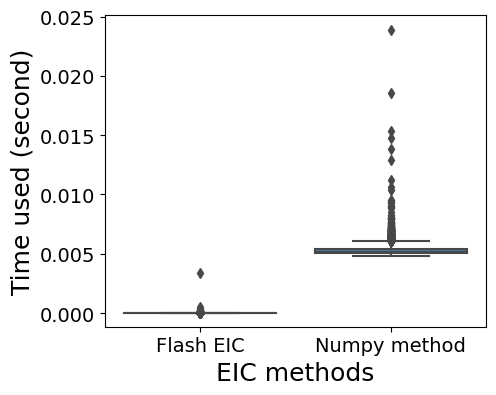

In [333]:
my_colors = ["#CE5F5A", "#5081BD",'#61D837']
fig = plt.figure(figsize = (5, 4))
# add color array to set_palette
# function of seaborn
p = sns.set_palette( my_colors )
ax = sns.boxplot(data=time_used_short2, x="method", y="time_used", palette='Set1')
ax.set_ylabel('Time used (second)',fontsize = 18)
ax.set_xlabel('EIC methods', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
fig.tight_layout()
plt.savefig(os.path.join(seminar_dir, 'p_short_method_2.png'))

In [ ]:
my_colors = ["#CE5F5A", "#5081BD",'#61D837']
fig = plt.figure(figsize = (12, 7))
# add color array to set_palette
# function of seaborn
p = sns.set_palette( my_colors )
ax = sns.boxplot(data=time_used_long, x="method", y="time_used", palette='Set1')
ax.set_ylabel('Time used (second)',fontsize = 18)
ax.set_xlabel('EIC methods', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
fig.tight_layout()
plt.savefig(os.path.join(seminar_dir, 'p_long_method.png'))

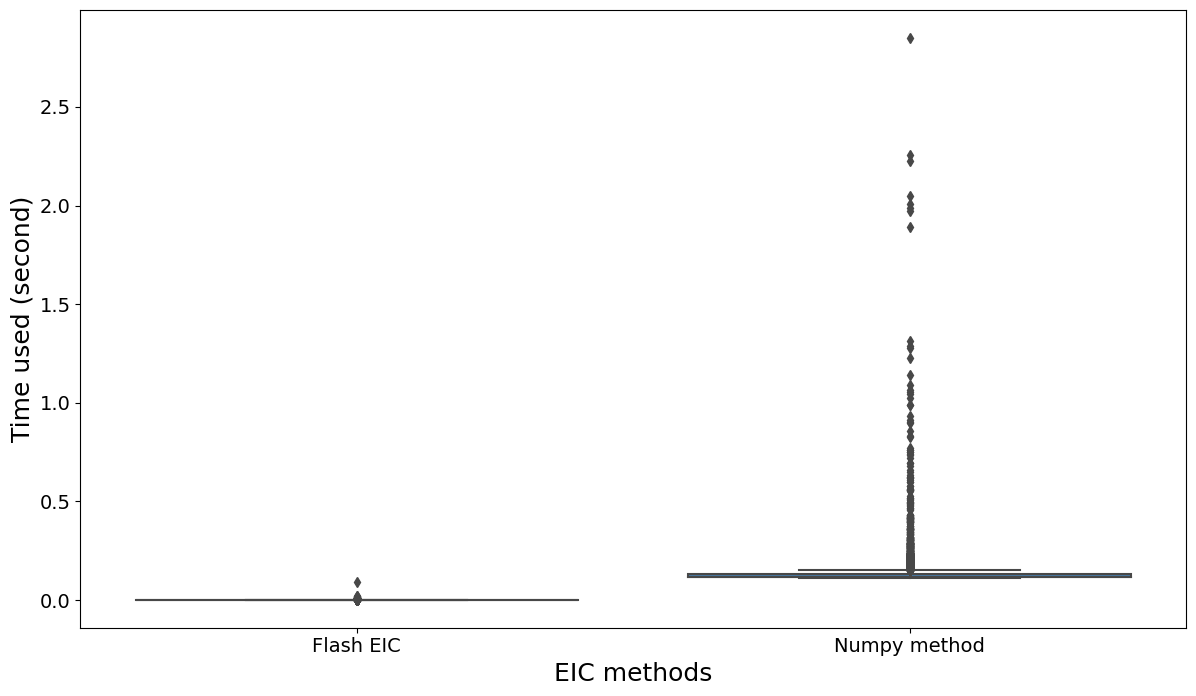

In [316]:
my_colors = ["#CE5F5A", "#5081BD",'#61D837']
fig = plt.figure(figsize = (12, 7))
# add color array to set_palette
# function of seaborn
p = sns.set_palette( my_colors )
ax = sns.boxplot(data=time_used_long, x="method", y="time_used", palette='Set1')
ax.set_ylabel('Time used (second)',fontsize = 18)
ax.set_xlabel('EIC methods', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
fig.tight_layout()
plt.savefig(os.path.join(seminar_dir, 'p_long_method.png'))

In [271]:
left_idx, right_idx = mass_sorted.searchsorted([371.1617-0.005, 371.1617+0.005])

In [228]:
run = pymzml.run.Reader(os.path.join(mzml_dir, 'SA2.mzML'))
time_dependent_intensities = []

MZ_2_FOLLOW = 371.1617
# run = pymzml.run.Reader(os.path.join(mzml_dir, 'SA2.mzML'))
# time_dependent_intensities = []
#
# MZ_2_FOLLOW = 70.06575775
time_used_pymzml = []
for i in tqdm(range(0,10000)):
    start = time.time()
    # metabo_eic = metabo_ms.get_eic_data(371.1617, mz_tol=0.005)
    # tt = trx.flash_eic(371.1617, mass_sorted, intensity_sorted, index_sorted)
    for spectrum in tqdm(run):
        if spectrum.ms_level == 1:
            has_peak_matches = spectrum.has_peak(MZ_2_FOLLOW)
            if has_peak_matches != []:
                for mz, I in has_peak_matches:
                    time_dependent_intensities.append(
                        [spectrum.scan_time_in_minutes(), I, mz]
                    )
    end = time.time()
    time_used_pymzml.append(end-start)

In [244]:
for scan in ms1['peaks']:
    break

In [ ]:
ms1.to_csv(os.path.join)

In [153]:
ord = string_search(std_list, 'if_halo_ref', False)

In [154]:
ord.query('halo_corr>0.75')

,formula,m/z,rt,targeted_fold_change,conc_ratio,if_halo_ref,halo_corr,corr_left,corr_right
8,C17H11F6N7O,444.0999,19.69,1.05,1/1,False,0.999949,0.944722,0.999889
18,C15H25NO3,268.1912,3.99,2.21,2/1,False,0.783016,0.000000,0.999714
19,C19H21N,264.1751,12.14,0.27,1/4,False,0.968720,-0.089860,0.999954
25,C11H11N5,214.1091,5.47,0.06,1/16,False,0.955227,0.946835,0.999952
31,C19H22N2,279.1860,5.06,0.99,1/1,False,0.795651,0.752372,0.999793
32,C16H24N2,245.2016,9.47,3.41,4/1,False,0.981416,-0.095034,0.999949
50,C50H75NO14,914.5281,31.81,0.21,1/4,False,0.958628,0.602757,0.983450
56,C22H28F2O5,411.1968,32.46,0.96,1/1,False,0.999516,0.999983,0.899401
80,C15H22N2O,247.1809,4.92,1.29,1/1,False,0.754362,-0.287024,0.999941
92,C20H23N,278.1906,9.94,0.78,1/1,False,0.777040,0.988415,0.999870


In [156]:
search_feature(feature_temp, 227.1546, 5.14)

,precursor_mz,rt_apex,rt_start,rt_end,ms1_intensity,n_scnas,ms1_scan_range,ion_trace_center,reci_snr,base_name,mz_offset
519,227.154882,5.159399,4.761539,5.983898,93242448.0,408.0,"[1588, 1997]",227.154866,1.343533e-13,NaN,0.000017


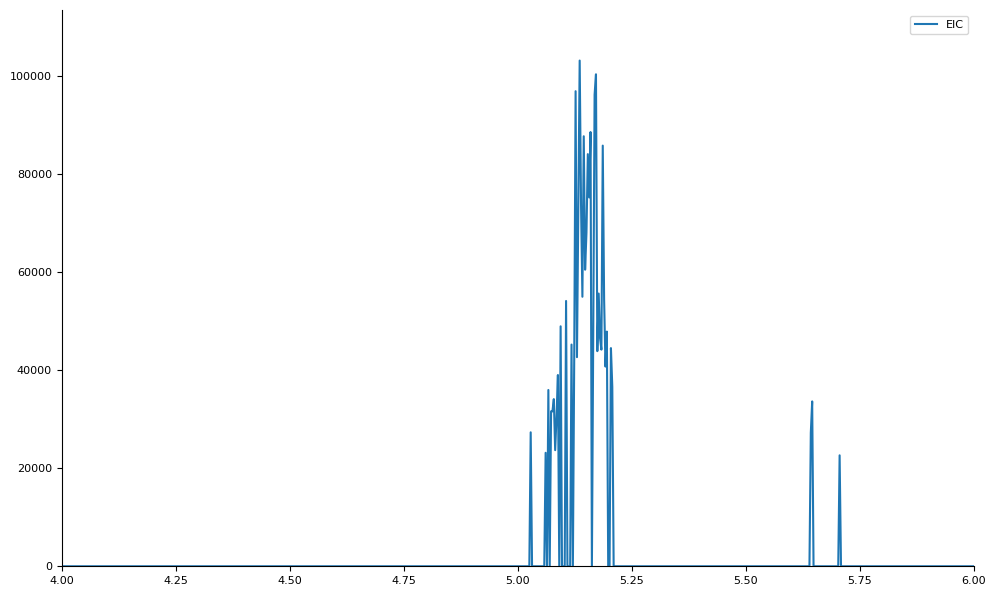

In [159]:
ion_trace_base = trx.flash_eic(227.154882, mass_sorted, intensity_sorted, index_sorted)
ion_trace_halo = trx.flash_eic(227.154882+iso_steps['Cl'], mass_sorted, intensity_sorted, index_sorted)
rds.EIC(rt_list, ion_trace_halo,
        base_line_series=ion_trace_halo,
        rt_start=4, rt_end=6)

In [128]:
search_feature(feature_temp, 308.1431, 3.94, rt_error=20)

,precursor_mz,rt_apex,rt_start,rt_end,ms1_intensity,n_scnas,ms1_scan_range,ion_trace_center,reci_snr,base_name,mz_offset
4257,308.14318,3.92372,3.73215,4.264453,16453381.0,180.0,"[1239, 1420]",308.143186,8.523551e-19,NaN,0.000006


In [144]:
ion_trace_base = trx.flash_eic(185.9776, mass_sorted, intensity_sorted, index_sorted)
# ion_trace_left = trx.flash_eic(308.1431-iso_steps['C'],mass_sorted, intensity_sorted, index_sorted)
ion_trace_halo = trx.flash_eic(185.9776+iso_steps['Cl'],mass_sorted, intensity_sorted, index_sorted, mass_error=0.002)

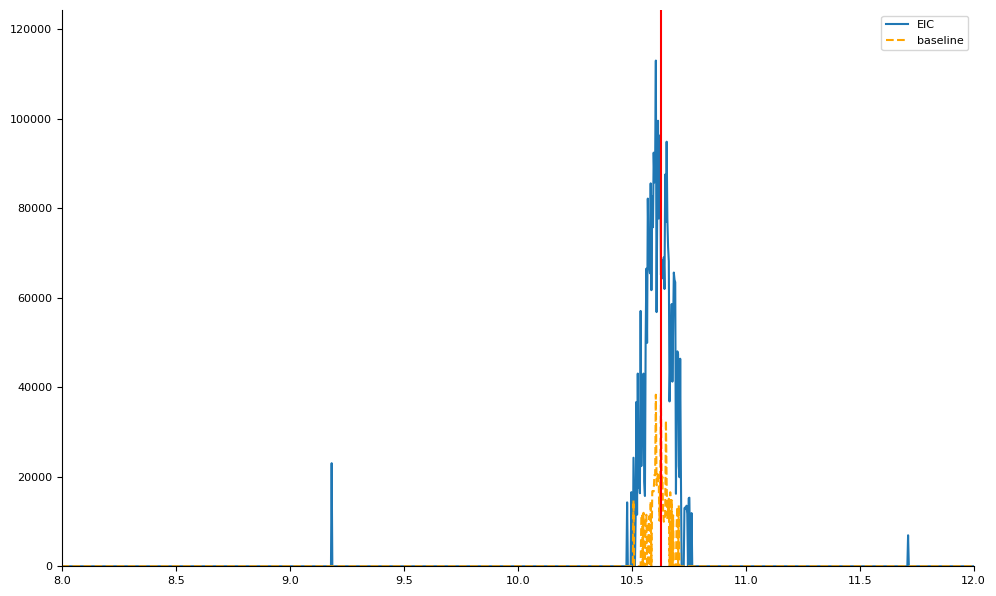

In [145]:
rds.EIC(rt_list, ion_trace_base, vlines_location_1=[10.63],
        base_line_series=ion_trace_halo,
        rt_start=8, rt_end=12)

In [57]:
found_feature

,precursor_mz,rt_apex,rt_start,rt_end,ms1_intensity,n_scnas,ms1_scan_range,ion_trace_center,reci_snr,base_name,mz_offset
1547,371.162257,18.939849,18.385409,20.253743,43924776.0,561.0,"[5913, 6475]",371.16227,1.821798e-15,NaN,0.000013


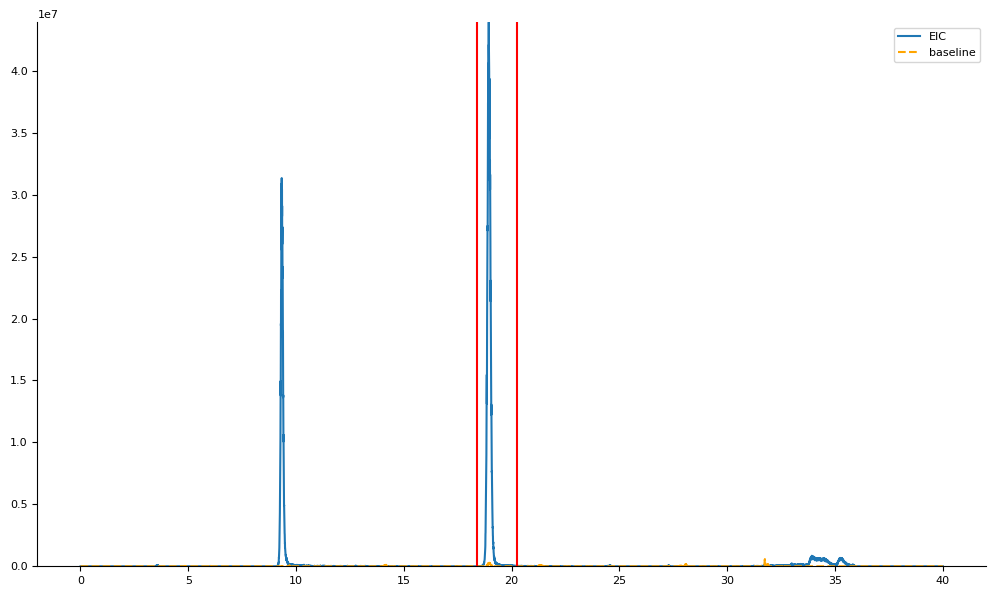

In [65]:
rds.EIC(rt_list, ion_trace_base,base_line_series=ion_trace_left, vlines_location_1=[18.385, 20.253])

In [838]:
for f in tqdm(file_list):
    ms1, ms2= rds.read_mzml(f,mzml_dir)
    mass_sorted, intensity_sorted, index_sorted, rt_list = trx.build_index(ms1)
    feature_temp= trx.get_features(mass_sorted, intensity_sorted, index_sorted, rt_list, n_neighbor=10)
    feature_temp.to_csv(os.path.join(pl_dir, f+'.csv'), index = False)
    break

  0%|          | 0/10 [10:19<?, ?it/s]


In [841]:
found = []
for index, row in tqdm(std_list.iterrows(), total = len(std_list)):
    tt = search_feature(feature_temp, pmz=row['m/z'], rt=row['rt'], rt_error=21)
    if len(tt)>0:
        found.append(True)
    else:
        found.append(False)
print(np.sum(found))

100%|██████████| 836/836 [00:05<00:00, 149.13it/s]

830


In [821]:
raw_apex_idx_all[-1]

10490.0

In [823]:
ion_trace = trx.flash_eic(329.219465, mass_sorted, intensity_sorted, index_sorted)

In [750]:
ion_trace = trx.flash_eic(157.035385, mass_sorted, intensity_sorted, index_sorted)

In [751]:
tt=trx.detect_all_peaks(ion_trace, n_neighbor=10, return_all=False)

In [774]:
6.71-7.24

-0.5300000000000002

In [784]:
rt_all

[0.57045102]

369.0734


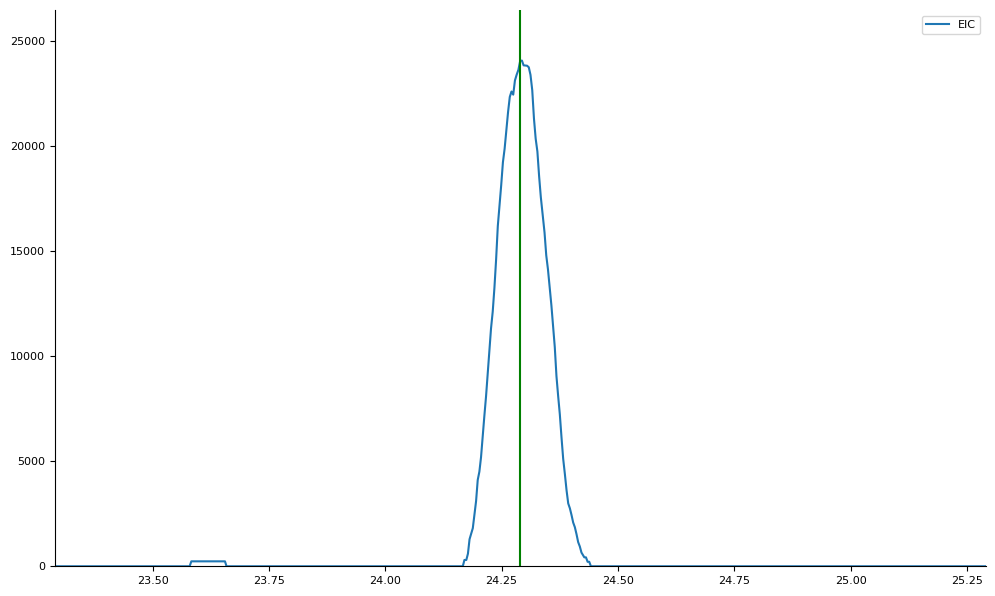

In [787]:
row = std_list[std_list['found']==False].iloc[6]
print(row['m/z'])
ion_trace = trx.flash_eic(row['m/z'], mass_sorted, intensity_sorted, index_sorted)
ion_trace_smoothed= trx.moving_average(ion_trace, 10)

tt=trx.detect_all_peaks(ion_trace, n_neighbor=10)
rt_all = [rt_list[int(x)] for x in tt[2]]
rds.EIC(rt_list, trx.moving_average(ion_trace, 10), vlines_location_1=[7.247],vlines_location_2=[row['rt']],
        rt_start=row['rt']-1, rt_end=row['rt']+1
        )

In [591]:
def is_halo(row, mass_sorted, intensity_sorted, index_sorted,threshold = 0.9):
    ion_trace_base = trx.moving_average(trx.flash_eic(row['precursor_mz'], mass_sorted, intensity_sorted, index_sorted),10)
    ion_trace_halo = trx.moving_average(trx.flash_eic(row['precursor_mz']+iso_steps['Cl'],mass_sorted, intensity_sorted, index_sorted),10)

    lst = literal_eval(row['ms1_scan_range'])
    corr,_ = pearsonr(ion_trace_base[lst[1]-1:lst[1]+2],
                      ion_trace_halo[lst[1]-1:lst[1]+2])
    if corr != corr:
        corr = 0
    if corr>threshold:
        return(True)
    else:
        return False

In [587]:
mass_sorted ,intensity_sorted, index_sorted, rt_list = trx.build_index(ms1)

In [586]:
feature_temp.sort_values(by = 'precursor_mz', ascending=True, inplace=True)

In [589]:
literal_eval(feature_temp.iloc[0]['ms1_scan_range'])

[1729, 1783, 1995]

In [593]:
is_halo_all =[]
for index, row in std_list.iterrows():
    feature_matched = search_feature(feature_temp, row['m/z'], row['rt'], pmz_sorted=True, rt_error=21)
    if len(feature_matched)>0:
        feature_matched = feature_matched[feature_matched['ms1_intensity']>0.9*feature_matched['ms1_intensity'].max()]
        feature_matched.sort_values(by = 'ms1_intensity', ascending=False, inplace=True)
        feature_unique = feature_matched.iloc[0]
        temp = is_halo(feature_unique, mass_sorted, intensity_sorted, index_sorted)
        is_halo_all.append(temp)
    else:
        is_halo_all.append(np.NAN)


In [594]:
std_list_halo = std_list.copy()

In [595]:
std_list_halo['is_halo']=is_halo_all

In [609]:
def _check_halo(formula):
    if 'Cl' in formula or 'Br' in formula or 'S' in formula:
        return True
    else:
        return False

In [610]:
row

formula                 C24H26BrN3O3
m/z                         484.1236
rt                             11.84
targeted_fold_change            1.01
conc_ratio                       1/1
is_halo                        False
is_halo_ref                     True
Name: 835, dtype: object

In [611]:
is_halo_ref = []
for index, row in std_list_halo.iterrows():
    is_halo_ref.append(_check_halo(row['formula']))
std_list_halo['is_halo_ref']=is_halo_ref

In [612]:
np.sum(std_list_halo['is_halo']!=std_list_halo['is_halo_ref'])

133

In [622]:
not_halo = string_search(std_list_halo, 'is_halo_ref', False)

In [624]:
np.sum(not_halo['is_halo']==True)

14

In [621]:
np.sum(actual_halo['is_halo']==False)

113

In [618]:
len(actual_halo)

328

In [619]:
213-328

-115

In [620]:
213/328

0.649390243902439

In [647]:
peak_statistics

(array([[1768, 1823, 1983]]), array([0.00144884]), array([1823.]))

In [627]:
row['rt']

18.85

In [632]:
(18.85-18.38)*40

18.800000000000097

In [553]:
intensity_list = trx.flash_eic(282.279762, mass_sorted, intensity_sorted, index_sorted)

In [524]:
seed_mass = 179.017223
ion_trace = trx.flash_eic(seed_mass, mass_sorted, intensity_sorted, index_sorted)
peaks_all, reci_snrs_all, raw_apex_idx_all = trx.detect_all_peaks(ion_trace, n_neighbor=n_neighbor, intensity_threshold=intensity_threshold)
idx_start, idx_end = mass_sorted.searchsorted([seed_mass-0.005, seed_mass+0.005])

In [529]:
peaks_all

[array([ 125,  163, 1099]), array([11312, 11345, 11542])]

In [534]:
mass = [179.017223,179.017173,179.017171]
intensity = [9.172616e+08,8.919868e+08,7.916861e+08]

In [535]:
np.sum(x*y/sum(intensity) for x, y in zip(mass, intensity))

179.01719002453785

In [538]:
ms1.iloc[159]['peaks']

array([[1.00014394e+02, 2.06673125e+06],
       [1.00112171e+02, 1.14735912e+06],
       [1.00984740e+02, 2.56145950e+06],
       ...,
       [1.18022518e+03, 2.87077062e+05],
       [1.28956789e+03, 2.70614875e+05],
       [1.45885551e+03, 3.00048688e+05]])

In [522]:
peaks_all

[array([ 125,  163, 1099]), array([11312, 11345, 11542])]

In [505]:
mass_range = mass_sorted[idx_start:idx_end]
index_range = index_sorted[idx_start:idx_end]

In [507]:
intensity_range = intensity_sorted[idx_start:idx_end]

In [515]:
target_mass = 179.017223

In [517]:
pmz_candidates = np.zeros(2*guess_step+1)
intensity_candidates = np.zeros(2*guess_step+1)
pmz_idx = 0

In [518]:
peak_apex=int(a)
guess_step = 1

In [521]:
peak_apex

35

In [519]:
for i in range(peak_apex-guess_step, peak_apex+guess_step+1):
    if len(intensity_range[index_range==i])>0:
        difference_array = np.absolute(mass_range[index_range==i]-target_mass)

        mass_anchor = difference_array.argmin()
        pmz_candidates[pmz_idx]=mass_range[index_range==i][mass_anchor]
        intensity_candidates[pmz_idx]=intensity_range[index_range==i][mass_anchor]

    if i == peak_apex:
        apex_intensity = intensity_candidates[pmz_idx]
    pmz_idx = pmz_idx+1

In [520]:
pmz_candidates

array([0., 0., 0.])

In [503]:
pmz_statistics = trx.guess_pmz(seed_mass, mass_sorted,
                                           intensity_sorted, index_sorted, idx_start, idx_end, int(a))

In [504]:
pmz_statistics

(nan, 0.0)

In [474]:
intensity_sorted_indexing = intensity_sorted.copy()
while np.max(intensity_sorted_indexing)>30000:
    seed_idx = np.argmax(intensity_sorted_indexing)
    seed_mass = mass_sorted[seed_idx]
    ion_trace = trx.flash_eic(seed_mass, mass_sorted, intensity_sorted, index_sorted)
    peaks_all, reci_snrs_all, raw_apex_idx_all = trx.detect_all_peaks(ion_trace, n_neighbor=10)
    idx_start, idx_end = mass_sorted.searchsorted([seed_mass-0.005, seed_mass+0.005])
    intensity_sorted_indexing[idx_start:idx_end]=0
    if len(peaks_all)>0:
        for p, r, a in zip(peaks_all, reci_snrs_all, raw_apex_idx_all):
            pmz_statistics = trx.guess_pmz(seed_mass, mass_sorted, intensity_sorted, index_sorted, idx_start, idx_end, int(a))

        # break

In [201]:
start = time.time()
feature_temp = trx.get_features(mass_sorted, intensity_sorted, index_sorted, rt_list, base_name=ms1.iloc[0]['base_name'], n_neighbor=10)
end = time.time()
print((end-start)/60)

9.912006016572317


In [243]:
intensity_sorted_indexing = intensity_sorted.copy()

In [247]:
seed_idx = np.argmax(intensity_sorted_indexing)

In [248]:
seed_mass = mass_sorted[seed_idx]

In [286]:
idx_start, idx_end = mass_sorted.searchsorted([seed_mass-0.005,seed_mass+0.005 ])
mass_offset = np.array([abs(x-seed_mass) for x in mass_sorted[idx_start:idx_end]])
mass_tol = np.mean(mass_offset)+3*np.std(mass_offset)
intensity_list = trx.flash_eic(seed_mass, mass_sorted, intensity_sorted, index_sorted,
                           mass_error=mass_tol)

In [287]:
peaks_all, reci_snrs, apex_intensity_smoothed_all= trx.detect_all_peaks(intensity_list,
                                                                    n_neighbor=n_neighbor,
                                                                    intensity_threshold=intensity_threshold)

In [583]:
feature_temp = pd.read_csv(os.path.join(pl_dir, 'SA2.csv'))

In [ ]:
for index, row in std_list.iterrows():


In [290]:
for p in peaks_all:
    apex_range_left = p[0]
    apex_range_right = p[2]
    apex_offset = np.argmax(intensity_list[apex_range_left:apex_range_right+1])
    apex_index = apex_range_left+apex_offset

    break


In [308]:
def guess_pmz(mass_sorted, intensity_sorted, index_sorted, idx_start, idx_end, peak_apex, guess_step = 1):
    # idx_start, idx_end = mass_sorted.searchsorted([seed_mass-mass_tolerance,seed_mass+mass_tolerance ])
    mass_range = mass_sorted[idx_start:idx_end]
    index_range = index_sorted[idx_start:idx_end]
    intensity_range = intensity_sorted[idx_start:idx_end]
    pmz_candidates = np.zeros(2*guess_step+1)
    intensity_candidates = np.zeros(2*guess_step+1)
    pmz_idx = 0

    for i in range(peak_apex-guess_step, apex_index+guess_step+1):
        intensity_anchor = np.argmax(intensity_range[index_range==i])
        pmz_candidates[pmz_idx]=mass_range[index_range==i][intensity_anchor]
        intensity_candidates[pmz_idx]=intensity_range[index_range==i][intensity_anchor]
        if i == peak_apex:
            apex_intensity = intensity_candidates[pmz_idx]
        pmz_idx = pmz_idx+1
    weighted_pmz = np.sum([x*y/np.sum(intensity_candidates) for x, y in zip(pmz_candidates, intensity_candidates)])
    return (weighted_pmz, apex_intensity)

In [310]:
intensity_list = trx.flash_eic(seed_mass, mass_sorted, intensity_sorted, index_sorted,
                           mass_error=0.005)

In [314]:
peak, reci_snr, apex_intensity_smoothed=trx.detect_one_peak(intensity_list, target_idx=np.argmax(intensity_list))

In [315]:
idx_start, idx_end = mass_sorted.searchsorted([seed_mass-0.005, seed_mass+0.005])

In [353]:
start = time.time()
tt = trx.get_features_alt(mass_sorted, intensity_sorted, index_sorted, rt_list, n_neighbor=10)
end = time.time()
print(end-start)

updated!


ValueError: attempt to get argmax of an empty sequence

In [366]:
ms1, ms2 = rds.read_mzml('SA2', mzml_dir)

mass_sorted, intensity_sorted, index_sorted, rt_list = trx.build_index(ms1)

In [373]:
std_list

,formula,m/z,rt,targeted_fold_change,conc_ratio,if_halo_ref,fill_%,mono_concensus,halo_concensus
0,C21H26N2S2,371.1617,18.85,0.47,1/2,True,1.0,False,True
1,C25H31NO6,442.2233,17.66,21.23,16/1,False,1.0,True,False
2,C14H17N3O2S,292.1118,3.01,1.91,2/1,True,1.0,True,True
3,C27H31N7OS,502.2395,22.78,1.06,1/1,True,1.0,True,True
4,C20H23NO4,342.1706,3.37,1.07,1/1,False,1.0,True,False
...,...,...,...,...,...,...,...,...,...
831,C24H29N3O2,392.2339,7.05,1.00,1/1,False,1.0,True,False
832,C19H19NOS,310.1254,7.73,1.06,1/1,True,1.0,True,True
833,C15H15NO2,242.1175,25.26,0.99,1/1,False,1.0,True,False
834,C15H15NO2,242.1179,26.45,1.05,1/1,False,1.0,True,False


In [384]:
intensity_list = trx.flash_eic(371.1617, mass_sorted, intensity_sorted, index_sorted)
intensity_list_iso = trx.flash_eic(371.1617+iso_steps['C'], mass_sorted, intensity_sorted, index_sorted)

In [505]:
feature_matched = search_feature(feature_temp, 308.1431)

,precursor_mz,rt_apex,rt_start,rt_end,ms1_intensity,n_scnas,ms1_scan_range,ion_trace_center,reci_snr,base_name,mz_offset
60998,308.139018,9.052951,8.860711,9.569991,2.441717e+06,229.0,"[2933, 3163]",308.134647,6.197925e-08,SB1.mzML,0.004371
4268,308.139018,9.052951,8.847872,9.876327,2.441717e+06,330.0,"[2929, 3260]",308.143407,5.862833e-16,SB1.mzML,0.004389
4269,308.142644,6.525360,6.397856,6.668678,4.708388e+05,89.0,"[2135, 2225]",308.143407,0.000000e+00,SB1.mzML,0.000764
4270,308.143114,32.302508,32.232369,32.370866,3.080928e+05,45.0,"[10098, 10144]",308.143407,0.000000e+00,SB1.mzML,0.000294
4267,308.143381,3.945772,3.745693,4.245885,1.784438e+07,169.0,"[1246, 1416]",308.143407,0.000000e+00,SB1.mzML,0.000026
4271,308.144749,16.476257,16.275860,16.626856,4.184586e+05,107.0,"[5253, 5361]",308.143407,0.000000e+00,SB1.mzML,0.001342
4272,308.146172,27.765353,27.659491,27.836593,5.769176e+04,55.0,"[8679, 8735]",308.143407,0.000000e+00,SB1.mzML,0.002764


In [514]:
lst = [0,2,3,4,3.9,6,4.2,4.5,3,2,1,0]

In [ ]:
x, y = line.get_xydata().T
ax.fill_between(x, 0, y, color=line.get_color(), alpha=alpha, **kwargs)


In [545]:
np.arange(7,len(lst) )

array([ 7,  8,  9, 10, 11])

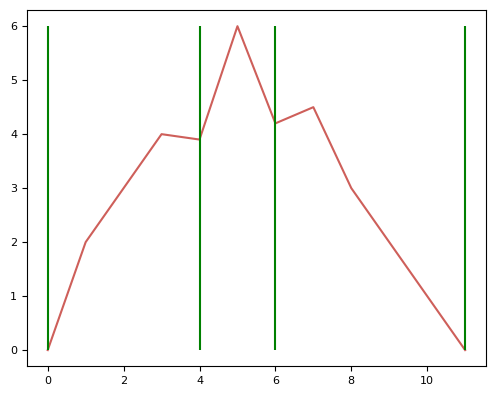

In [625]:
fig = plt.figure(figsize = (5, 4))
# add color array to set_palette
# function of seaborn
ax = sns.lineplot(lst)
# baseline =
# ax.fill_between(np.arange(len(lst)),np.array(lst), color="blue", alpha=0.3)
for v in [0,4,6,11]:
    plt.vlines(x = v, ymin=0, ymax=6, colors='green')
# plt.hlines(xmin = 0, xmax = 11, y=0.2, colors='yellow',linestyle='dashed')
# ax.fill_between(np.array([4,5,6]),np.array(lst[4:7]), color="green", alpha=0.3)
# ax.fill_between(np.arange(6,len(lst) ),np.array(lst[6:]), color="orange", alpha=0.3)
# ax.fill_between(np.arange(4),np.array(lst[0:4]), color="red", alpha=0.3)
fig.tight_layout()
plt.savefig(os.path.join(seminar_dir, 'peak_detection_1.5.png'))


In [523]:
l1 = ax.lines[0]

In [526]:
l1.get_xydata()[:,0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

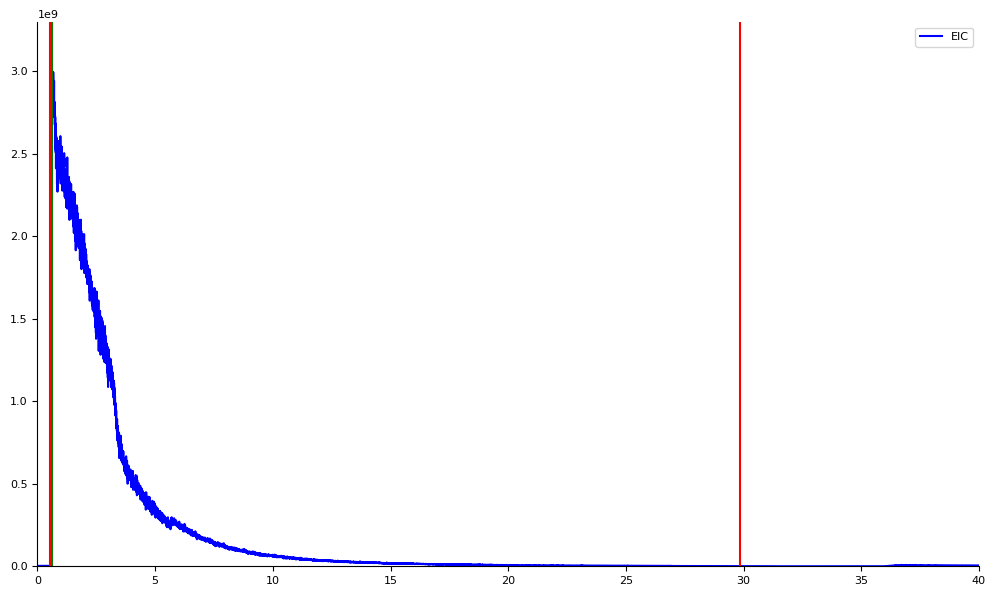

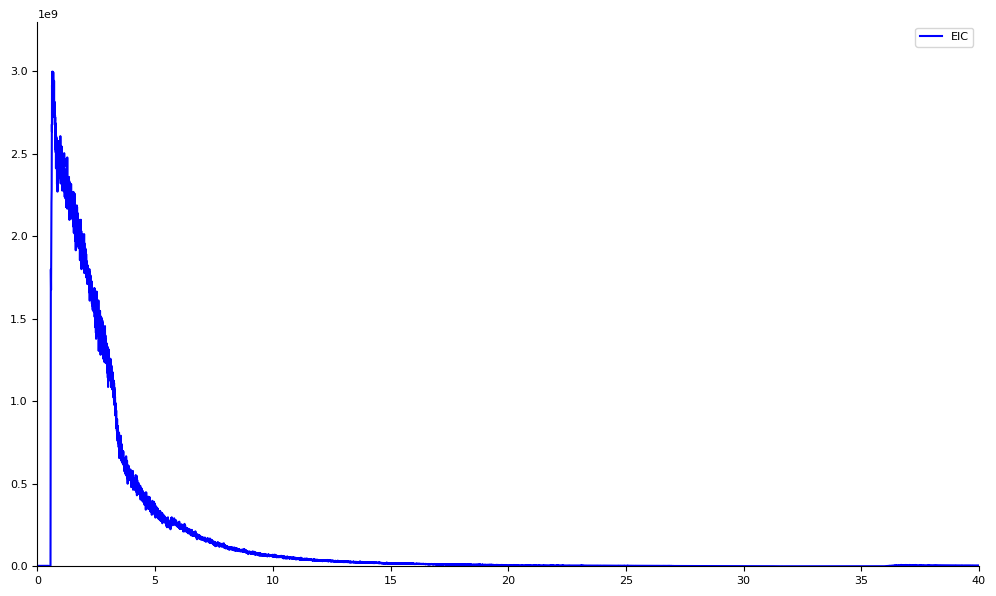

In [513]:
# row = std_list.iloc[14]
# ion_trace_base = trx.flash_eic(185.9776, mass_sorted, intensity_sorted, index_sorted)
# ion_trace_left = trx.flash_eic(308.1431-iso_steps['C'],mass_sorted, intensity_sorted, index_sorted)
# ion_trace_halo = trx.flash_eic(185.9776+iso_steps['Cl'],mass_sorted, intensity_sorted, index_sorted, mass_error=0.002)
# feature_matched = search_feature(feature_temp, 371.1617, row['rt'], rt_error=21)
# feature_matched.sort_values(by = 'ms1_intensity', ascending=False, inplace=True)
intensity_list = trx.flash_eic(157.035462, mass_sorted, intensity_sorted, index_sorted)
# range = literal_eval(feature_matched.iloc[0]['ms1_scan_range'])
rds.EIC(rt_list,
        # trx.moving_average(intensity_list,10),
        intensity_list,
        rt_start=0,rt_end=40,
        vlines_location_1=[0.524806,29.841466],
        vlines_location_2=[0.621800],
        # #
        savepath=os.path.join(seminar_dir, 'ugly_vline4.png')
        )
rds.EIC(rt_list,
        intensity_list,
        rt_start=0,rt_end=40,
        # vlines_location_1=[24.27,24.66],
        # vlines_location_2=[24.573095],
        #
        savepath=os.path.join(seminar_dir, 'ugly4.png')
        )

In [406]:
feature_matched.iloc[0]['ms1_scan_range']

'[5899, 6424]'

In [415]:
feature_matched = search_feature(feature_temp, row['m/z'], row['rt'], rt_error=21)

In [417]:
feature_matched = search_feature(feature_temp, row['m/z'])

In [421]:
60*(28.399199-row['rt'])

-37.24806000000001

In [425]:
feature_matched = search_feature(feature_temp, row['m/z'], row['rt'], rt_error=21)

In [426]:
feature_matched

,precursor_mz,rt_apex,rt_start,rt_end,ms1_intensity,n_scnas,ms1_scan_range,ion_trace_center,reci_snr,base_name,mz_offset
8244,408.134390,29.01674,28.921077,29.144907,156711.609375,67.0,"[9067, 9135]",408.130057,0.000000e+00,SB1.mzML,0.004333
4042,408.134645,29.01799,28.883657,29.425042,156711.609375,159.0,"[9055, 9215]",408.138861,1.015067e-15,SB1.mzML,0.004216


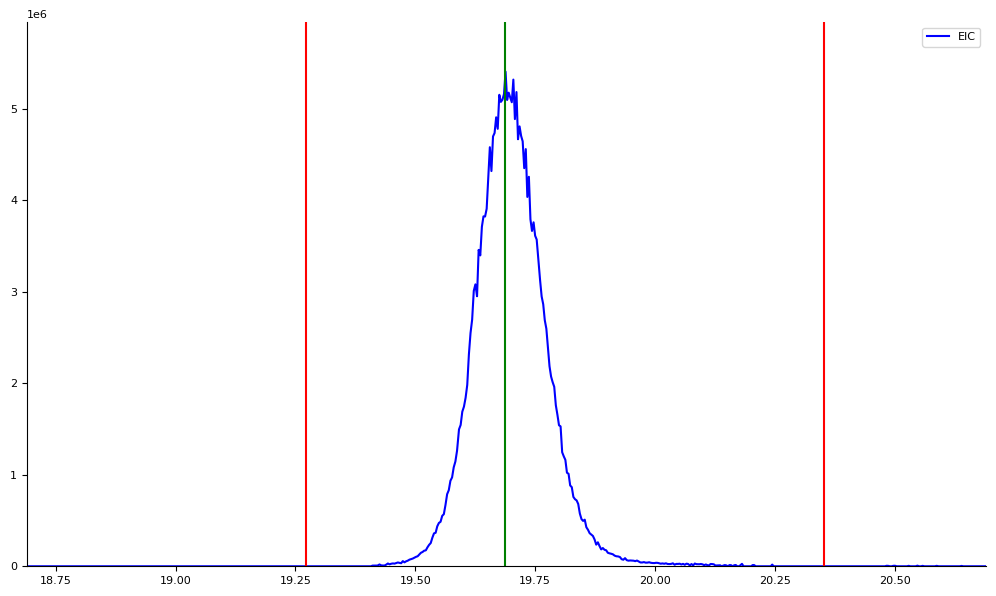

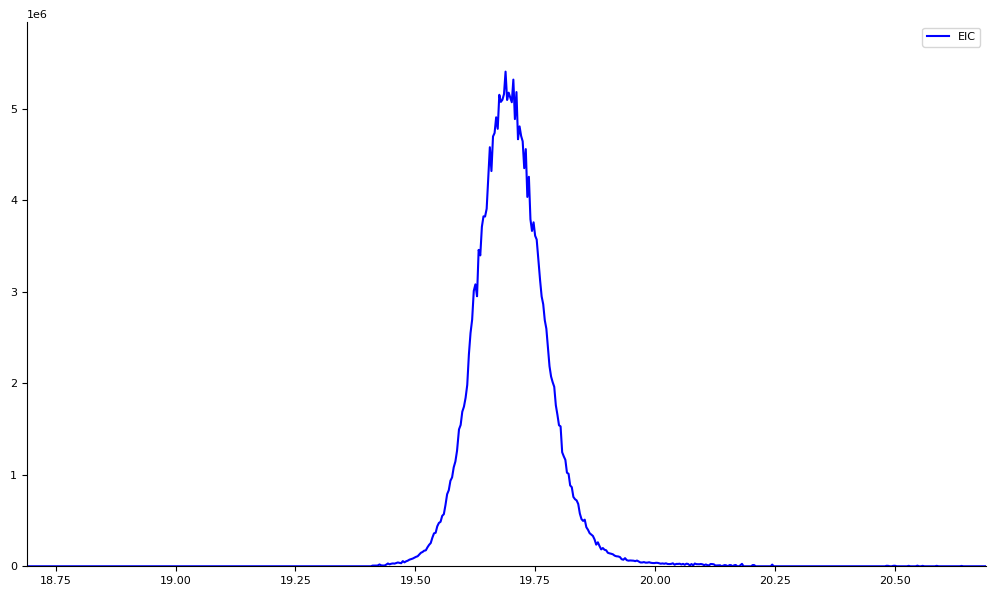

In [454]:
row = std_list.iloc[14]
feature_matched = search_feature(feature_temp, row['m/z'], row['rt'], rt_error=21)
feature_matched.sort_values(by = 'ms1_intensity', ascending=False, inplace=True)
intensity_list = trx.flash_eic(row['m/z'], mass_sorted, intensity_sorted, index_sorted)
range = literal_eval(feature_matched.iloc[0]['ms1_scan_range'])
rds.EIC(rt_list,
        # trx.moving_average(intensity_list,10),
        intensity_list,
        rt_start=row['rt']-1,rt_end=row['rt']+1,
        vlines_location_1=[rt_list[range[0]], rt_list[range[1]]],
        vlines_location_2=[feature_matched.iloc[0]['rt_apex']],

         # savepath=os.path.join(seminar_dir, 'middle_vline2.png')
        )
rds.EIC(rt_list,
        # trx.moving_average(intensity_list,10),
        intensity_list,
        rt_start=row['rt']-1,rt_end=row['rt']+1,
        # vlines_location_1=[rt_list[range[0]], rt_list[range[1]]],
        # vlines_location_2=[feature_matched.iloc[0]['rt_apex']],

        # savepath=os.path.join(seminar_dir, 'middle2.png')
        )

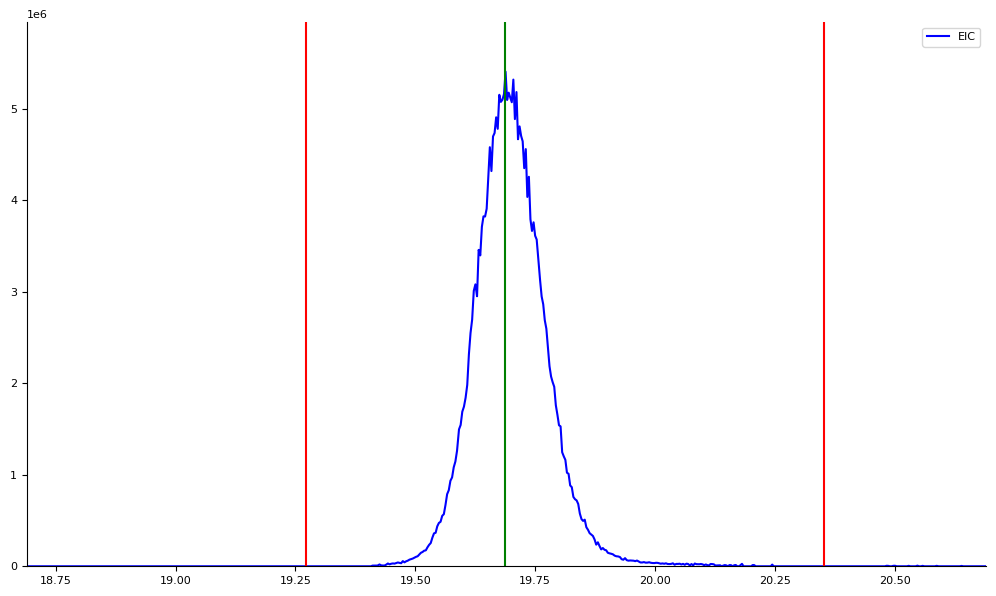

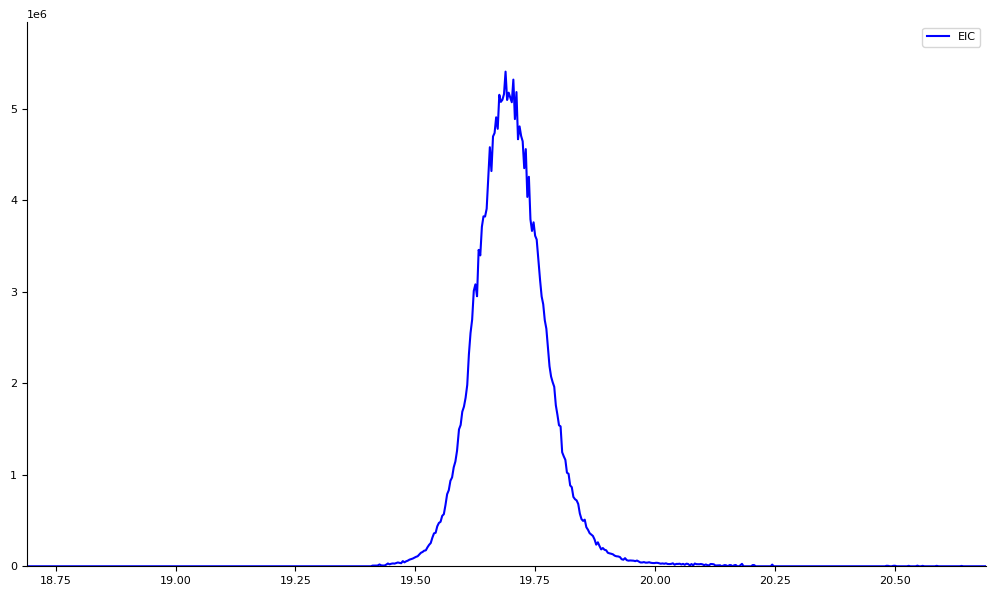

In [456]:
rds.EIC(rt_list,
        # trx.moving_average(intensity_list,10),
        intensity_list,
        rt_start=row['rt']-1,rt_end=row['rt']+1,
        vlines_location_1=[rt_list[range[0]], rt_list[range[1]]],
        vlines_location_2=[feature_matched.iloc[0]['rt_apex']],

        savepath=os.path.join(seminar_dir,  'good_vline.png')
        )
rds.EIC(rt_list,
        # trx.moving_average(intensity_list,10),
        intensity_list,
        rt_start=row['rt']-1,rt_end=row['rt']+1,
        # vlines_location_1=[rt_list[range[0]], rt_list[range[1]]],
        # vlines_location_2=[feature_matched.iloc[0]['rt_apex']],

        savepath=os.path.join(seminar_dir, 'good.png')
        )

In [440]:
row

formula                 C31H38N8O3
m/z                       571.3155
rt                            5.54
targeted_fold_change          1.01
conc_ratio                     1/1
if_halo_ref                  False
fill_%                         1.0
mono_concensus                True
halo_concensus               False
Name: 9, dtype: object

In [346]:
rt_list[9764]

31.099798

In [336]:
guess_step =1

In [337]:
mass_range = mass_sorted[idx_start:idx_end]
index_range = index_sorted[idx_start:idx_end]
intensity_range = intensity_sorted[idx_start:idx_end]
pmz_candidates = np.zeros(2*guess_step+1)
intensity_candidates = np.zeros(2*guess_step+1)
pmz_idx = 0

In [298]:
np.sum(index_range==198)

1

In [300]:
np.argmax(intensity_range[index_range==198])

0

In [272]:
index_range[index_range==197]

array([197])

In [395]:
# def find_one_roi_alt(intensity_list, n_neighbor = 5):
#     intensity_list_smoothed= trx.moving_average(intensity_list, n_neighbor)
#     apex_idx = np.argmax(intensity_list_smoothed)
#     # if np.min(intensity_list_smoothed)>0:
#     #     return([0, apex_idx, len(intensity_list_smoothed)-1])
#     # left_side = intensity_list_smoothed[:apex_idx]
#     # left_side_flip = np.flip(left_side)
#     # right_side = intensity_list_smoothed[apex_idx+1:]
#     # if len(left_side)>0:
#     #     left_idx = apex_idx-(np.argmax(left_side_flip==0)+1)
#     # else:
#     #     left_idx = 0
#     # if len(right_side)>0:
#     #     right_idx = apex_idx+np.argmax(right_side==0)+1
#     # else:
#     #     right_side = len(intensity_list_smoothed)-1
#     # return(np.array([left_idx, apex_idx, right_idx]))
#     left_idx = apex_idx
#     right_idx = apex_idx
#     for i in range(1, apex_idx+1):
#         left_idx=apex_idx-i
#         if intensity_list_smoothed[left_idx]==0:
#             break
#     for i in range(1, len(intensity_list_smoothed)-apex_idx):
#         right_idx=apex_idx+i
#         if intensity_list_smoothed[right_idx]==0:
#             break
#     return([left_idx, apex_idx, right_idx])

In [473]:
def find_one_roi(intensity_list, n_neighbor = 5, if_smooth = True):
    if if_smooth == True:
        intensity_list_smoothed= trx.moving_average(intensity_list, n_neighbor)
    else:
        intensity_list_smoothed = intensity_list
    apex_idx = np.argmax(intensity_list_smoothed)
    if np.min(intensity_list_smoothed)>0:
        return([0, apex_idx, len(intensity_list_smoothed)-1])
    left_side = intensity_list_smoothed[:apex_idx]
    left_side_flip = np.flip(left_side)
    right_side = intensity_list_smoothed[apex_idx+1:]
    if len(left_side)>0:
        left_idx = apex_idx-(np.argmax(left_side_flip==0)+1)
    else:
        left_idx = 0
    if len(right_side)>0:
        right_idx = apex_idx+np.argmax(right_side==0)+1
    else:
        right_idx = len(intensity_list_smoothed)-1
    return(np.array([left_idx, apex_idx, right_idx]))

In [468]:
def find_all_rois(intensity_list, n_neighbor = 5, intensity_tolerance = 30000):
    intensity_list_smoothed= trx.moving_average(intensity_list, n_neighbor)
    # print(np.max(intensity_list_smoothed))
    roi_all = []
    # num_grater_than_zero = np.sum(intensity_sorted_indexing>intensity_tolerance)
    while np.max(intensity_list_smoothed)>intensity_tolerance:
        current_roi = find_one_roi(intensity_list_smoothed, if_smooth=False)
        roi_all.append(current_roi)
        intensity_list_smoothed[current_roi[0]:current_roi[2]+1]=0
        # if np.sum(intensity_list_smoothed>0)==num_grater_than_zero:
        #     print('not zeroing out')
        #     return(seed_mass, mass_tol)
        # else:
        #     num_grater_than_zero = np.sum(intensity_list_smoothed>intensity_tolerance)
        # # apex_idx = np.argmax(intensity_list_smoothed)
        # left_side = intensity_list_smoothed[:apex_idx]
        # left_side_flip = np.flip(left_side)
        # right_side = intensity_list_smoothed[apex_idx+1:]
        # if len(left_side)>0:
        #     left_idx = apex_idx-(np.argmax(left_side_flip==0)+1)
        # else:
        #     left_idx = 0
        # if len(right_side)>0:
        #     right_idx = apex_idx+np.argmax(right_side==0)+1
        # else:
        #     right_idx = len(intensity_list_smoothed)-1
        # roi_all.append(np.array([left_idx, apex_idx, right_idx]))
    return(roi_all)


In [571]:
feature_temp = pd.read_csv(os.path.join(pl_dir, 'SA2.csv'))
# feature_temp.sort_values(by = 'precursor_mz', ascending=True, inplace=True)
feature_temp.reset_index(inplace=True, drop=True)
strat = time.time()
# feature_dereplicate = pd.DataFrame()
# with tqdm(total=len(mass_sorted)) as pbar:
#     while len(feature_temp)>0:
#         seed_feature = feature_temp.iloc[np.argmax(feature_temp['ms1_intensity'])]
#         duplicates = search_feature(feature_temp, pmz=seed_feature['precursor_mz'], rt=seed_feature['rt_apex'], rt_error=1, mass_error=0.001, pmz_sorted= True)
#         feature_temp.drop(duplicates.index.tolist(), inplace=True)
#         if len(duplicates)==1:
#             feature_dereplicate= pd.concat([feature_dereplicate, duplicates], ignore_index=True)
#         else:
#             duplicates['pmz_offset']=abs(duplicates['ion_trace_center']-duplicates['precursor_mz'])
#             duplicates.sort_values(by = 'pmz_offset', ascending=True)
#             # duplicates.drop_duplicates(subset = 'ms1_intensity', keep='first', inplace = True)
#             feature_dereplicate= pd.concat([feature_dereplicate, pd.DataFrame([duplicates.iloc[0]])], ignore_index=True)
#         pbar.update(1)
# end = time.time()



In [570]:
feature_temp['pmz_offset']=abs(feature_temp['precursor_mz']-feature_temp['ion_trace_center'])

In [581]:

28/39

0.717948717948718

In [562]:
offset_mins = feature_temp.groupby(['precursor_mz', 'rt_apex']).pmz_offset.transform(min)

feature_grouped = feature_temp.loc[feature_temp.pmz_offset == offset_mins]
feature_grouped.reset_index(inplace=True, drop=True)
feature_grouped.sort_values(by = 'precursor_mz', ascending=True, inplace=True)

feature_dereplicate = pd.DataFrame()
feature_grouped_working = feature_grouped.copy()
with tqdm(total=len(feature_grouped)) as pbar:
    while len(feature_grouped)>0:
        seed_feature = feature_grouped.iloc[np.argmax(feature_grouped['ms1_intensity'])]
        feature_neighbors = search_feature(feature_grouped, pmz = seed_feature['precursor_mz'], rt = seed_feature['rt_apex'], mass_error=0.001, rt_error=1, pmz_sorted=True)
        if len(feature_neighbors)==1:
            feature_dereplicate = pd.concat([feature_dereplicate, feature_neighbors], ignore_index=True)
        else:
            feature_neighbors.sort_values(by = 'pmz_offset', ascending=True)
            feature_dereplicate=pd.concat([feature_dereplicate,pd.DataFrame([feature_neighbors.iloc[0]]) ], ignore_index=True)
        feature_grouped.drop(feature_neighbors.index.tolist(), inplace = True)
    #     seed_feature = tt.iloc[np.argmax(tt['ms1_intensity'])]
    #     duplicates = search_feature(feature_temp, pmz=seed_feature['precursor_mz'], rt=seed_feature['rt_apex'], rt_error=1, mass_error=0.001, pmz_sorted= True)
    #     feature_temp.drop(duplicates.index.tolist(), inplace=True)
    #     if len(duplicates)==1:
    #         feature_dereplicate= pd.concat([feature_dereplicate, duplicates], ignore_index=True)
    #     else:
    #         duplicates['pmz_offset']=abs(duplicates['ion_trace_center']-duplicates['precursor_mz'])
    #         duplicates.sort_values(by = 'pmz_offset', ascending=True)
    #         # duplicates.drop_duplicates(subset = 'ms1_intensity', keep='first', inplace = True)
    #         feature_dereplicate= pd.concat([feature_dereplicate, pd.DataFrame([duplicates.iloc[0]])], ignore_index=True)
        pbar.update(1)
end = time.time()

 94%|█████████▍| 46550/49493 [01:33<00:05, 495.65it/s]


In [566]:
(0.629930-0.658084)*60

-1.6892400000000007

In [569]:
100.548338-100.672308

-0.12396999999999991

In [568]:
feature_dereplicate.sort_values(by = 'precursor_mz')

,precursor_mz,rt_apex,rt_start,rt_end,ms1_intensity,ms1_intensity_smoothed,n_scnas,ms1_scan_range,ion_trace_center,reci_snr,ion_trace_offset,base_name,pmz_offset
25467,100.014235,5.334833,5.175013,5.969390,1.583211e+05,5.899558e+04,267.0,"[1729, 1783, 1995]",100.014287,0.000000,0.001113,SA2.mzML,0.000051
3322,100.014300,0.594403,0.544899,0.754079,2.719298e+06,1.819541e+06,73.0,"[147, 164, 219]",100.014287,0.002685,0.001113,SA2.mzML,0.000013
17818,100.014318,35.994122,35.881179,39.328739,2.607262e+05,1.684807e+05,981.0,"[11319, 11357, 12299]",100.014287,0.014203,0.001113,SA2.mzML,0.000032
2870,100.014323,0.499369,0.005082,0.544899,3.437068e+06,1.917332e+06,148.0,"[0, 132, 147]",100.011523,0.001395,0.003478,SA2.mzML,0.002800
36879,100.014333,10.039861,9.210654,17.905591,8.882105e+04,5.238617e+04,2720.0,"[3055, 3322, 5774]",100.014287,0.000000,0.001113,SA2.mzML,0.000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15322,1465.577793,31.702193,31.642058,31.748997,3.191995e+05,1.087202e+05,37.0,"[9937, 9957, 9973]",1465.577299,0.001874,0.003428,SA2.mzML,0.000494
20640,1471.860554,31.693168,31.639092,31.740137,2.128347e+05,8.020994e+04,35.0,"[9936, 9954, 9970]",1471.859263,0.002957,0.004217,SA2.mzML,0.001291
22088,1472.862143,31.688435,31.639092,31.743087,1.939350e+05,6.298496e+04,36.0,"[9936, 9952, 9971]",1472.862222,0.001530,0.000553,SA2.mzML,0.000079
29271,1476.813814,31.697350,31.642058,31.746045,1.291286e+05,3.303436e+04,36.0,"[9937, 9955, 9972]",1476.813917,0.001410,0.000449,SA2.mzML,0.000103
